# Fallback - Retention Model Rollover
* StellarAlgo Data Science
* Grant Donst
* Oct 19, 2022

In [17]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from pycaret.classification import *
from shared_utilities import helpers

In [18]:
CLUSTER = "prod-app-elbu"
DATABASE = "stlrcflredblacks"
LKUPCLIENTID = "101"
TRAINING_YEAR = 2021
SCORING_YEAR = 2022

## Model Training

In [19]:
df = helpers.get_retention_dataset(
    cluster=CLUSTER,
    database=DATABASE,
    lkupclientid=LKUPCLIENTID,
    start_year=2010,
    end_year=SCORING_YEAR
)

df.shape

Authorized as AROASQ4JELIXYLYV6P4UV:rkazmerik@stellaralgo.com


(20049, 24)

In [20]:
# choose the features for the stellar base retention model
features = [
    "recentdate",
	"clientcode",
	"dimcustomermasterid",
	"lkupclientid",
	"productgrouping",
	"year",
	"attendancepercent",
	"disttovenue",
    "inperson_contact",
	"missed_games_1",
	"missed_games_2",
	"missed_games_over_2",
	"recency",
	"tenure",
	"totalspent",
	"isnextyear_buyer"
]

# copy your main dataframe
df_dataset = df

# choose the features & train year & test year
df_dataset = df_dataset[features]
df_dataset["year"] = pd.to_numeric(df_dataset["year"])
df_dataset = df_dataset.loc[df_dataset["year"] <= TRAINING_YEAR]

#Fail safes
df = df.dropna(subset=["recentdate"]).reset_index(drop=True)
df['tenure'] = df['tenure'].fillna(0)

df_train = df_dataset.sample(frac=0.85, random_state=786)
df_train = df_train.reset_index(drop=True)

df_eval = df.drop(df_train.index)
df_eval = df_eval.reset_index(drop=True)

# print out the number of records for training and eval
print('Data for Modeling: ' + str(df_train.shape))
print('Unseen Data For Predictions: ' + str(df_eval.shape), end="\n\n")

Data for Modeling: (12917, 16)
Unseen Data For Predictions: (7132, 24)



In [21]:
setup(
    data= df_train, 
    target="isnextyear_buyer", 
    train_size = 0.85,
    data_split_shuffle=True,
    date_features=[
        "recentdate"
    ],
    ignore_features=[
        "clientcode",
		"dimcustomermasterid",
		"lkupclientid",
		"productgrouping",
		"year"
    ],
    silent=True,
    verbose=False,
    numeric_features=[
        "attendancepercent",
		"disttovenue",
        "inperson_contact",
		"missed_games_1",
		"missed_games_2",
		"missed_games_over_2",
		"recency",
		"tenure",
		"totalspent"
    ]
);

In [22]:
model_matrix = compare_models(
    fold=10,
    include=["xgboost"]
)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
xgboost,Extreme Gradient Boosting,0.7939,0.8785,0.7846,0.7318,0.7572,0.5785,0.5797,0.3810


In [23]:
best_model = create_model(model_matrix);
final_model = finalize_model(best_model);

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.7905,0.8718,0.7572,0.7375,0.7473,0.5685,0.5686
1,0.7878,0.8768,0.7867,0.7210,0.7524,0.5673,0.5690
2,0.7796,0.8709,0.7667,0.7158,0.7403,0.5493,0.5503
3,0.7878,0.8755,0.7844,0.7219,0.7519,0.5671,0.5686
4,0.7933,0.8786,0.7844,0.7308,0.7567,0.5774,0.5785
5,0.8087,0.8838,0.8178,0.7419,0.7780,0.6107,0.6129
6,0.8160,0.8934,0.8022,0.7616,0.7814,0.6228,0.6234
7,0.7923,0.8822,0.7689,0.7362,0.7522,0.5736,0.5740
8,0.7914,0.8713,0.8044,0.7197,0.7597,0.5765,0.5793


/opt/miniconda3/envs/stellar/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/opt/miniconda3/envs/stellar/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/opt/miniconda3/envs/stellar/lib/python3.8/site-packages/xgboost

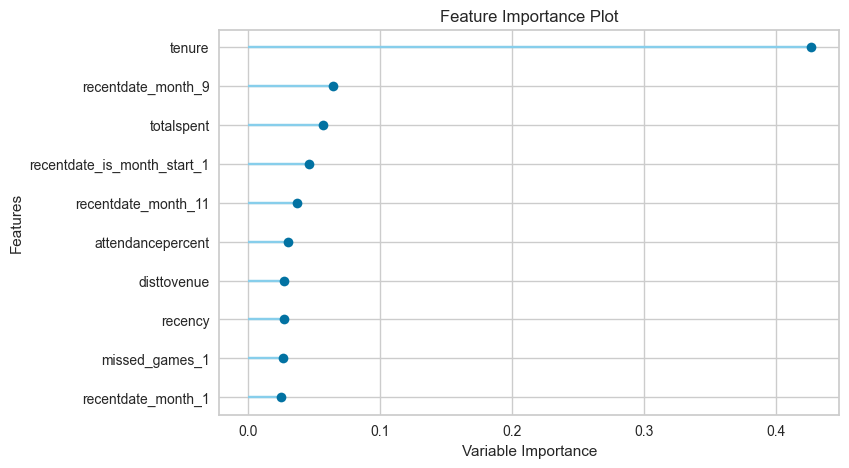

In [24]:
plot_model(final_model, plot='feature')

## Model Inference

### Let's load in our inference data and get retention scores using the model:

In [25]:
df_inference = df.loc[df["year"] >= SCORING_YEAR]
#df_inference = df_inference.fillna(0)

# remove the target column from the inference df
df_inference = df_inference[features]

df_inference = df_inference.drop(columns=["isnextyear_buyer"], axis=1)

#df_inference = df_inference.reindex(sorted(df_inference.columns), axis=1)

df_inference['tenure'] = df_inference['tenure'].fillna(0)

df_inference.shape

(4853, 15)

In [26]:
df_scores = predict_model(final_model, data=df_inference, raw_score=True)

df_scores["score"] = df_scores["Score_1"].astype("float64").fillna(0)*100

Text(0.5, 1.0, 'RETENTION SCORES:      PROD-APP-ELBU     STLRCFLREDBLACKS')

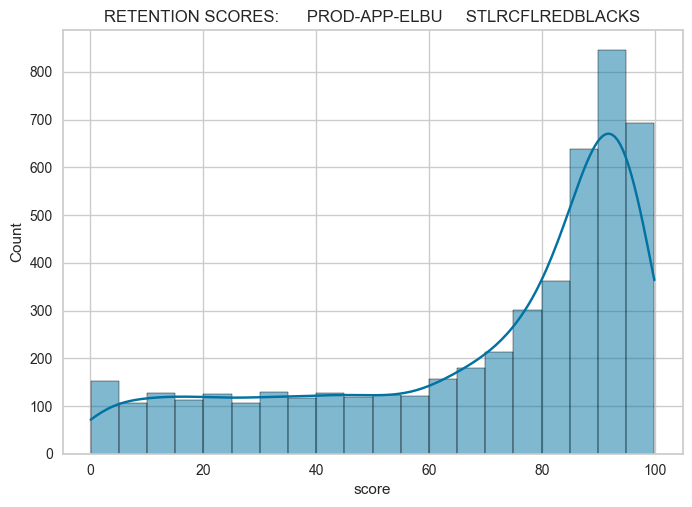

In [27]:
sns.histplot(data=df_scores, x='score', bins= 20, kde=True)    
plt.title(f"RETENTION SCORES:      {CLUSTER.upper()}     {DATABASE.upper()}", fontsize = 12)